In [ ]:
# This does PCA background subtraction of the AC Her data, specifically
# 1. reads in PCA component cube
# 2. masks and subtracts the median (just a constant) from each science frame
# 2. decomposes each science frame into its PCA components (with a mask over the PSF)
# 3. subtracts the reconstructed background
# 4. saves the background-subtracted images

# created 2018 Aug 20 by E.S.

In [1]:
from modules import *
import numpy as np
import matplotlib.pyplot as plt
import scipy
from astropy.io import fits
import pandas as pd
from datetime import datetime
import os
import sklearn
from sklearn.decomposition import PCA
from sklearn.decomposition import RandomizedPCA
import time
from regions import PixCoord, CircleSkyRegion, CirclePixelRegion, PolygonPixelRegion
from pyregion import read_region_as_imagecoord, get_mask
import time
import multiprocessing as mp
from multiprocessing import Process, Queue, Pool
%matplotlib inline
#%matplotlib qt

In [2]:
# stem 

stem = ('/home/../../media/unasemaje/Elements/lbti_data_reduction/180524_fizeau_ac_her/01_BPM_readout_glitch_correction/')
#stem = ('/Users/nyumbani/Downloads/')

# FCN TO DO PCA SUBTRACTION OF RANGE OF
# SCIENCE FRAMES

In [3]:
def pca_fit_and_subtract_parallel(inputArray):
    
    '''
    INPUTS:
    a 1D array with 
    [0]: cube_start_framenum: starting frame number of the PCA component cube
    [1]: cube_stop_framenum: stopping frame number (inclusive)  "  "
    [2]: sci_framenum: science images to subtract from
    [3]: n_PCA: number of PCA components to reconstruct the background with
    
    OUTPUTS:
    none; the background-subtracted FITS files are written back out
    '''
    
    # unpack values
    cube_start_framenum = inputArray[0]
    cube_stop_framenum = inputArray[1]
    sci_framenum = inputArray[2]
    n_PCA = inputArray[3]

    # read in PCA cube
    cube_string = (stem+'pca_cubes/background_PCA_hunzikerStyle_seqStart_'
                 +str("{:0>6d}".format(cube_start_framenum))+'_seqStop_'+str("{:0>6d}".format(cube_stop_framenum))+'.fits')
    pca_cube = fits.getdata(cube_string,0,header=False)

    # apply mask over weird detector regions to PCA cube
    pca_cube = np.multiply(pca_cube,mask_weird)
    
    # science filename string (note this has already been classically background-subtracted)
    img_string = stem+'../02_classical_background_subted/02b_second_attempt/lm_180524_'+str("{:0>6d}".format(sci_framenum))+'.fits'

    # if FITS science file exists in the first place
    if ((np.mod(sci_framenum,1) == 0) & os.path.isfile(img_string)): 
            
        start_time = time.time()
        print('Found file '+'lm_180524_'+str("{:0>6d}".format(sci_framenum))+'.fits')    
        
        # read in science image
        sciImg, header = fits.getdata(img_string,0,header=True)
        
        # apply mask over weird detector regions to science image
        sciImg = np.multiply(sciImg,mask_weird)
        
        ## mask the PSF
        
        # define region
        psf_loc = find_airy_psf(sciImg) # center of science PSF
        print('PSF location:')
        print(psf_loc)
        radius = 30.
        center = PixCoord(x=psf_loc[1], y=psf_loc[0])
        region = CirclePixelRegion(center, radius)
        mask_psf_region = region.to_mask()
        # apply the mask to science array
        psf_mask = np.ones(np.shape(sciImg)) # initialize arrays of same size as science image
        mask_psf_region.data[mask_psf_region.data == 1] = np.nan  # make zeros within mask cutout (but not in the mask itself) nans
        mask_psf_region.data[mask_psf_region.data == 0] = 1
        ##mask_psf_region.data[mask_psf_region.data == -99999] = 0 # have to avoid nans in the linear algebra
        psf_mask[mask_psf_region.bbox.slices] = mask_psf_region.data  # place the mask cutout (consisting only of 1s) onto the array of nans
        sciImg_masked = np.multiply(sciImg,psf_mask) # this is now the masked science frame        
        
        # subtract the median (just a constant) from the remaining science image
        sciImg_psf_masked = np.subtract(sciImg_masked,np.nanmedian(sciImg_masked)) # where PSF is masked
        sciImg_psf_not_masked = np.subtract(sciImg,np.nanmedian(sciImg_masked)) # where PSF is not masked
        
        # apply the PSF mask to PCA slices, with which we will do the fitting
        pca_cube_masked = np.multiply(pca_cube,psf_mask) 
    
        ## PCA-decompose
        
        # flatten the science array and PCA cube 
        pca_not_masked_1ds = np.reshape(pca_cube,(np.shape(pca_cube)[0],np.shape(pca_cube)[1]*np.shape(pca_cube)[2]))
        sci_masked_1d = np.reshape(sciImg_psf_masked,(np.shape(sciImg_masked)[0]*np.shape(sciImg_masked)[1]))
        pca_masked_1ds = np.reshape(pca_cube_masked,(np.shape(pca_cube_masked)[0],np.shape(pca_cube_masked)[1]*np.shape(pca_cube_masked)[2]))
    
        ## remove nans from the linear algebra
        
        # indices of finite elements over a single flattened frame
        idx = np.logical_and(np.isfinite(pca_masked_1ds[0,:]), np.isfinite(sci_masked_1d)) 
        
        # reconstitute only the finite elements together in another PCA cube and a science image
        pca_masked_1ds_noNaN = np.nan*np.ones((len(pca_masked_1ds[:,0]),np.sum(idx))) # initialize array with slices the length of number of finite elements
        for t in range(0,len(pca_masked_1ds[:,0])): # for each PCA component, populate the arrays without nans with the finite elements
            pca_masked_1ds_noNaN[t,:] = pca_masked_1ds[t,idx]
        sci_masked_1d_noNaN = np.array(1,np.sum(idx)) # science frame
        sci_masked_1d_noNaN = sci_masked_1d[idx] 
        
        # the vector of component amplitudes
        soln_vector = np.linalg.lstsq(pca_masked_1ds_noNaN[0:n_PCA,:].T, sci_masked_1d_noNaN)
        
        # reconstruct the background based on that vector
        # note that the PCA components WITHOUT masking of the PSF location is being
        # used to reconstruct the background
        recon_backgrnd_2d = np.dot(pca_cube[0:n_PCA,:,:].T, soln_vector[0]).T
        
        # do the actual subtraction
        sciImg_subtracted = np.subtract(sciImg_psf_not_masked,recon_backgrnd_2d)
        
        # save reconstructed background for checking
        hdul = fits.PrimaryHDU(recon_backgrnd_2d, header=header)
        hdul.writeto(stem + '../03_pca_background_subted/reconstructed_backgrounds/recon_background_'+str("{:0>6d}".format(sci_framenum))+'_nPCA'+str("{:0>3d}".format(n_PCA))+'.fits', 
                     overwrite=True)
        
        # save masked science frame BEFORE background-subtraction
        hdul = fits.PrimaryHDU(sciImg_psf_masked, header=header)
        hdul.writeto(stem + '../03_pca_background_subted/masked_science_frames/masked_science_frame_pre_bkgrnd_subt_'+str("{:0>6d}".format(sci_framenum))+'.fits', 
                     overwrite=True) 
            
        # write masked background-subtracted science frame (and occasionally background frames) out
        background_subtracted_masked = np.multiply(sciImg_subtracted,mask_weird)
        background_subtracted_masked = np.multiply(background_subtracted_masked,psf_mask)
        hdul = fits.PrimaryHDU(background_subtracted_masked, header=header)
        hdul.writeto(stem + '../03_pca_background_subted/masked_science_frames/masked_science_frame_post_bkgrnd_subt_'+str("{:0>6d}".format(sci_framenum))+'_nPCA'+str("{:0>3d}".format(n_PCA))+'.fits', 
                     overwrite=True)
            
        
        # write background-subtracted science frame (and occasionally background frames) out
        hdul = fits.PrimaryHDU(sciImg_subtracted, header=header)
        hdul.writeto(stem + '../03_pca_background_subted/lm_180524_'+str("{:0>6d}".format(sci_framenum))+'_nPCA'+str("{:0>3d}".format(n_PCA))+'.fits', 
                     overwrite=True)
        print('Frame '+str("{:0>6d}".format(sci_framenum))+' written out. PCA = '+str(n_PCA))
        print('Elapsed time:')
        elapsed_time = time.time() - start_time
        print('--------------------------------------------------------------')
        print(elapsed_time)
            
    else:
        
        print('No file '+'lm_180524_'+str("{:0>6d}".format(sci_framenum))+'.fits')
        print('--------------------------------------------------------------')

In [4]:
# for background subtracting with 100 PCA components

nPCA = 100

# array containing, for each nod, 
# [0]: starting frame of background sequence
# [1]: ending frame of background sequence (inclusive)
# [2]: starting science frame to background-subtract
# [3]: ending science frame to background-subtract (inclusive)
# [4]: number of PCA components to use in background reconstruction

# this contains the info for the whole dataset
parameterArray = [[2083, 2282, 83, 2082, nPCA],
                 [4683, 4882, 2283, 4682, nPCA],
                 [7285, 7483, 4883, 7284, nPCA],
                 [9484, 9683, 7484, 9483, nPCA],
                 [11684, 11883, 9682, 11683, nPCA],
                 [13884, 14083, 11884, 13883, nPCA],
                 [16084, 16283, 14084, 16083, nPCA],
                 [18284, 18483, 16284, 18283, nPCA],
                 [25884, 26083, 18484, 21683, nPCA],
                 [25884, 26083, 23884, 25883, nPCA],
                 [28084, 28283, 26084, 28083, nPCA],
                 [28084, 28283, 28284, 28883, nPCA],
                 [30884, 31083, 28884, 30883, nPCA],
                 [32884, 33083, 31084, 32883, nPCA],
                 [34884, 35083, 33084, 34883, nPCA],
                 [37084, 37283, 35084, 37083, nPCA],
                 [39284, 39483, 37284, 39283, nPCA],
                 [41484, 41683, 39484, 41483, nPCA],
                 [44577, 44776, 41684, 44576, nPCA],
                 [46777, 47076, 44777, 46776, nPCA],
                 [49077, 49276, 47077, 49076, nPCA],
                 [51277, 51676, 49277, 51276, nPCA],
                 [53677, 53876, 51677, 53676, nPCA],
                 [55877, 56108, 53877, 55876, nPCA],
                 [58110, 58308, 56109, 58109, nPCA],
                 [60309, 60508, 58309, 60308, nPCA],
                 [62509, 62708, 60509, 62508, nPCA],
                 [64709, 64908, 62709, 64708, nPCA],
                 [66909, 67108, 64909, 66908, nPCA]]

In [5]:
def return_array_one_block(sliceArray):
    '''
    This takes a 1D array with background frame range, science frame range, and N_PCA information
    and returns an expanded array where each row corresponds to a single science array
    '''
    
    # INPUT: an array containing 
    # [0]: starting frame of background sequence
    # [1]: ending frame of background sequence (inclusive)
    # [2]: starting science frame to background-subtract
    # [3]: ending science frame to background-subtract (inclusive)
    # [4]: number of PCA components to use in background reconstruction
    
    # OUTPUT: an array of arrays where each element corresponds to the 
    # parameters of a single science image (i.e., the input array elements
    # [0], [1], [4] are replicated for each science frame. 
    
    # unpack some values
    science_start_frame = sliceArray[2]
    science_end_frame = sliceArray[3]
    
    sliceArrayTiled = np.tile(sliceArray,(science_end_frame-science_start_frame+1,1)) # tile, where each row corresponds to a science frame
    sliceArrayTiled2 = np.delete(sliceArrayTiled,2,1) # delete col [2]

    # convert new col [2] (old col [3]) to be entries for individual frame numbers
    for sciframeNum in range(science_start_frame,science_end_frame+1):
        t = int(sciframeNum-science_start_frame) # index denoting the row
        sliceArrayTiled2[t][2] = int(sciframeNum) # insert frame number
    
    # The table now involves columns
    # [0]: background_start_frame
    # [1]: background_end_frame
    # [2]: science frame number
    # [3]: number of PCA components to reconstruct the background

    return sliceArrayTiled2

In [6]:
def main():
    
    ncpu = mp.cpu_count()
    print('Number cores: '+str(int(ncpu)))
    
    start_time_very_beginning = time.time()
    
    # loop over every nod position and pool the reduction over all science frames in that nod
    for r in range(0,np.shape(parameterArray)[0]):
        pool = Pool(ncpu) # create pool object
        print('Working on reducing parameter array')
        print(parameterArray[r])
        indivSciFramesArray = return_array_one_block(parameterArray[r]) # take info for that nod block, and return array for individual science frames
        list_dicts = pool.map(pca_fit_and_subtract_parallel,indivSciFramesArray) # map the individual science frames across cores
        print('---------------------------------')
    
    elapsed_time_since_beginning = time.time() - start_time_very_beginning
    print('Total elapsed time: '+str(elapsed_time_since_beginning))

In [ ]:
##################

# do it!
if __name__ == '__main__':
    main()

Number cores: 4
Working on reducing parameter array
[2083, 2282, 83, 2082, 100]
Found file lm_180524_000333.fits
Found file lm_180524_000083.fits
PSF location:
[50, 803]
PSF location:
[50, 803]
Found file lm_180524_000208.fits
Found file lm_180524_000458.fits
PSF location:
[50, 802]
PSF location:
[50, 802]
Frame 000333 written out. PCA = 100
Elapsed time:
--------------------------------------------------------------
5.44356703758
Frame 000083 written out. PCA = 100
Elapsed time:
--------------------------------------------------------------
5.41832995415
Frame 000208 written out. PCA = 100
Elapsed time:
Frame 000458 written out. PCA = 100
Elapsed time:
--------------------------------------------------------------
--------------------------------------------------------------
5.64069700241
5.61696982384
Found file lm_180524_000084.fits
PSF location:
[50, 802]
Found file lm_180524_000334.fits
PSF location:
[50, 802]
Found file lm_180524_000209.fits
Found file lm_180524_000459.fits
PSF 

Process PoolWorker-4:
Traceback (most recent call last):
  File "/home/unasemaje/anaconda3/envs/py27/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/unasemaje/anaconda3/envs/py27/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/unasemaje/anaconda3/envs/py27/lib/python2.7/multiprocessing/pool.py", line 113, in worker
    result = (True, func(*args, **kwds))
  File "/home/unasemaje/anaconda3/envs/py27/lib/python2.7/multiprocessing/pool.py", line 65, in mapstar
    return map(*args)
  File "<ipython-input-3-cfc4652865e7>", line 67, in pca_fit_and_subtract_parallel
    pca_cube_masked = np.multiply(pca_cube,psf_mask)
KeyboardInterrupt
Process PoolWorker-1:
Traceback (most recent call last):
  File "/home/unasemaje/anaconda3/envs/py27/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/unasemaje/anaconda3/envs/py27/lib/python2.7/m

Found file lm_180524_000583.fits
PSF location:
[50, 803]
Found file lm_180524_000708.fits
PSF location:
[50, 802]
Found file lm_180524_000958.fits
Found file lm_180524_000833.fits
PSF location:
PSF location:
[51, 802]
[51, 802]


Process PoolWorker-8:
Traceback (most recent call last):
  File "/home/unasemaje/anaconda3/envs/py27/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/unasemaje/anaconda3/envs/py27/lib/python2.7/multiprocessing/process.py", line 114, in run
Process PoolWorker-7:
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/unasemaje/anaconda3/envs/py27/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/unasemaje/anaconda3/envs/py27/lib/python2.7/multiprocessing/pool.py", line 113, in worker
    result = (True, func(*args, **kwds))
  File "/home/unasemaje/anaconda3/envs/py27/lib/python2.7/multiprocessing/pool.py", line 65, in mapstar
  File "/home/unasemaje/anaconda3/envs/py27/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/unasemaje/anaconda3/envs/py27/lib/python2.7/multiprocessing/pool.py", l

Found file lm_180524_001708.fits
Found file lm_180524_001583.fits
PSF location:
[51, 802]
PSF location:
[51, 803]
Found file lm_180524_001833.fits
PSF location:
[51, 803]
Found file lm_180524_001958.fits
PSF location:
[51, 803]
Frame 001708 written out. PCA = 100
Elapsed time:
--------------------------------------------------------------
5.90969204903
Frame 001583 written out. PCA = 100
Elapsed time:
--------------------------------------------------------------
6.16252088547
Frame 001833 written out. PCA = 100
Elapsed time:
--------------------------------------------------------------
5.98497915268
Frame 001958 written out. PCA = 100
Elapsed time:
--------------------------------------------------------------
5.74269199371
Found file lm_180524_001709.fits
Found file lm_180524_001584.fits
PSF location:
[51, 803]
PSF location:
[51, 803]
Found file lm_180524_001834.fits
PSF location:
[51, 803]
Found file lm_180524_001959.fits
PSF location:
[51, 801]


# Below are the non-parallelized snippets used to make the parallel code above

In [6]:
def pca_fit_and_subtract(cube_start_framenum, 
                         cube_stop_framenum, 
                         sci_framenum_start, 
                         sci_framenum_stop,
                         n_PCA):
    
    '''
    INPUTS:
    cube_start_framenum: starting frame number of the PCA component cube
    cube_stop_framenum: stopping frame number (inclusive)  "  "
    sci_framenum_start: starting frame number of the range of science images to subtract from
    sci_framenum_stop: stopping frame number 
    
    OUTPUTS:
    none; the background-subtracted FITS files are written back out
    '''

    # read in PCA cube
    cube_string = (stem+'pca_cubes/background_PCA_hunzikerStyle_seqStart_'
                 +str("{:0>6d}".format(cube_start_framenum))+'_seqStop_'+str("{:0>6d}".format(cube_stop_framenum))+'.fits')
    pca_cube = fits.getdata(cube_string,0,header=False)

    # apply mask over weird detector regions to PCA cube
    pca_cube = np.multiply(pca_cube,mask_weird)

    # loop over science frames and reconstruct the background
    for sci_framenum in range(sci_framenum_start,sci_framenum_stop):
    
        # science filename string (note this has already been classically background-subtracted)
        img_string = stem+'../02_classical_background_subted/02b_second_attempt/lm_180524_'+str("{:0>6d}".format(sci_framenum))+'.fits'

        # if FITS science file exists in the first place
        if ((np.mod(sci_framenum,1) == 0) & os.path.isfile(img_string)): 
            
            start_time = time.time()
            print('Found file '+'lm_180524_'+str("{:0>6d}".format(sci_framenum))+'.fits')    
        
            # read in science image
            sciImg, header = fits.getdata(img_string,0,header=True)
        
            # apply mask over weird detector regions to science image
            sciImg = np.multiply(sciImg,mask_weird)
        
            ## mask the PSF
        
            # define region
            psf_loc = find_airy_psf(sciImg) # center of science PSF
            print('PSF location:')
            print(psf_loc)
            radius = 30.
            center = PixCoord(x=psf_loc[1], y=psf_loc[0])
            region = CirclePixelRegion(center, radius)
            mask_psf_region = region.to_mask()
            # apply the mask to science array
            psf_mask = np.ones(np.shape(sciImg)) # initialize arrays of same size as science image
            mask_psf_region.data[mask_psf_region.data == 1] = np.nan  # make zeros within mask cutout (but not in the mask itself) nans
            mask_psf_region.data[mask_psf_region.data == 0] = 1
            ##mask_psf_region.data[mask_psf_region.data == -99999] = 0 # have to avoid nans in the linear algebra
            psf_mask[mask_psf_region.bbox.slices] = mask_psf_region.data  # place the mask cutout (consisting only of 1s) onto the array of nans
            sciImg_masked = np.multiply(sciImg,psf_mask) # this is now the masked science frame        
        
            # subtract the median (just a constant) from the remaining science image
            sciImg_psf_masked = np.subtract(sciImg_masked,np.nanmedian(sciImg_masked)) # where PSF is masked
            sciImg_psf_not_masked = np.subtract(sciImg,np.nanmedian(sciImg_masked)) # where PSF is not masked
        
            # apply the PSF mask to PCA slices, with which we will do the fitting
            pca_cube_masked = np.multiply(pca_cube,psf_mask) 
    
            ## PCA-decompose
        
            # flatten the science array and PCA cube 
            pca_not_masked_1ds = np.reshape(pca_cube,(np.shape(pca_cube)[0],np.shape(pca_cube)[1]*np.shape(pca_cube)[2]))
            sci_masked_1d = np.reshape(sciImg_psf_masked,(np.shape(sciImg_masked)[0]*np.shape(sciImg_masked)[1]))
            pca_masked_1ds = np.reshape(pca_cube_masked,(np.shape(pca_cube_masked)[0],np.shape(pca_cube_masked)[1]*np.shape(pca_cube_masked)[2]))
    
            ## remove nans from the linear algebra
        
            # indices of finite elements over a single flattened frame
            idx = np.logical_and(np.isfinite(pca_masked_1ds[0,:]), np.isfinite(sci_masked_1d)) 
        
            # reconstitute only the finite elements together in another PCA cube and a science image
            pca_masked_1ds_noNaN = np.nan*np.ones((len(pca_masked_1ds[:,0]),np.sum(idx))) # initialize array with slices the length of number of finite elements
            for t in range(0,len(pca_masked_1ds[:,0])): # for each PCA component, populate the arrays without nans with the finite elements
                pca_masked_1ds_noNaN[t,:] = pca_masked_1ds[t,idx]
            sci_masked_1d_noNaN = np.array(1,np.sum(idx)) # science frame
            sci_masked_1d_noNaN = sci_masked_1d[idx] 
        
            # the vector of component amplitudes
            soln_vector = np.linalg.lstsq(pca_masked_1ds_noNaN[0:n_PCA,:].T, sci_masked_1d_noNaN)
        
            # reconstruct the background based on that vector
            # note that the PCA components WITHOUT masking of the PSF location is being
            # used to reconstruct the background
            recon_backgrnd_2d = np.dot(pca_cube[0:n_PCA,:,:].T, soln_vector[0]).T
        
            # do the actual subtraction
            sciImg_subtracted = np.subtract(sciImg_psf_not_masked,recon_backgrnd_2d)
        
            # save reconstructed background for checking
            hdul = fits.PrimaryHDU(recon_backgrnd_2d, header=header)
            hdul.writeto(stem + '../03_pca_background_subted/reconstructed_backgrounds/recon_background_'+str("{:0>6d}".format(sci_framenum))+'_nPCA'+str("{:0>3d}".format(n_PCA))+'.fits', 
                     overwrite=True)
        
            # save masked science frame BEFORE background-subtraction
            hdul = fits.PrimaryHDU(sciImg_psf_masked, header=header)
            hdul.writeto(stem + '../03_pca_background_subted/masked_science_frames/masked_science_frame_'+str("{:0>6d}".format(sci_framenum))+'.fits', 
                     overwrite=True) 
            
            # write masked background-subtracted science frame (and occasionally background frames) out
            background_subtracted_masked = np.multiply(sciImg_subtracted,mask_weird)
            background_subtracted_masked = np.multiply(background_subtracted_masked,psf_mask)
            hdul = fits.PrimaryHDU(background_subtracted_masked, header=header)
            hdul.writeto(stem + '../03_pca_background_subted/masked_science_frames/masked_science_frame_'+str("{:0>6d}".format(sci_framenum))+'_nPCA'+str("{:0>3d}".format(n_PCA))+'.fits', 
                     overwrite=True)
            
        
            # write background-subtracted science frame (and occasionally background frames) out
            hdul = fits.PrimaryHDU(sciImg_subtracted, header=header)
            hdul.writeto(stem + '../03_pca_background_subted/lm_180524_'+str("{:0>6d}".format(sci_framenum))+'_nPCA'+str("{:0>3d}".format(n_PCA))+'.fits', 
                     overwrite=True)
            print('Frame '+str("{:0>6d}".format(sci_framenum))+' written out. PCA = '+str(n_PCA))
            print('Elapsed time:')
            elapsed_time = time.time() - start_time
            print('--------------------------------------------------------------')
            print(elapsed_time)
            
        else:
        
            print('No file '+'lm_180524_'+str("{:0>6d}".format(sci_framenum))+'.fits')
            print('--------------------------------------------------------------')

In [7]:


test1 = pca_fit_and_subtract(2083, 2282, 83, 2082, nPCA)
test2 = pca_fit_and_subtract(4683, 4882, 2283, 4682, nPCA)
test3 = pca_fit_and_subtract(7285, 7483, 4883, 7284, nPCA)
test = pca_fit_and_subtract(9484, 9683, 7484, 9483, nPCA)
test = pca_fit_and_subtract(11684, 11883, 9682, 11683, nPCA)
test = pca_fit_and_subtract(13884, 14083, 11884, 13883, nPCA)
test = pca_fit_and_subtract(16084, 16283, 14084, 16083, nPCA)
test = pca_fit_and_subtract(18284, 18483, 16284, 18283, nPCA)
test = pca_fit_and_subtract(25884, 26083, 18484, 21683, nPCA) # this is an awkward one, since we didnt get off frames
test = pca_fit_and_subtract(25884, 26083, 23884, 25883, nPCA)
test = pca_fit_and_subtract(28084, 28283, 26084, 28083, nPCA) 
test = pca_fit_and_subtract(28084, 28283, 28284, 28883, nPCA) # note this is for some extra science frames on this nod
test = pca_fit_and_subtract(30884, 31083, 28884, 30883, nPCA)
test = pca_fit_and_subtract(32884, 33083, 31084, 32883, nPCA)
test = pca_fit_and_subtract(34884, 35083, 33084, 34883, nPCA)
test = pca_fit_and_subtract(37084, 37283, 35084, 37083, nPCA)
test = pca_fit_and_subtract(39284, 39483, 37284, 39283, nPCA)
test = pca_fit_and_subtract(41484, 41683, 39484, 41483, nPCA)
test = pca_fit_and_subtract(44577, 44776, 41684, 44576, nPCA)
test = pca_fit_and_subtract(46777, 47076, 44777, 46776, nPCA)
test = pca_fit_and_subtract(49077, 49276, 47077, 49076, nPCA)
test = pca_fit_and_subtract(51277, 51676, 49277, 51276, nPCA)
test = pca_fit_and_subtract(53677, 53876, 51677, 53676, nPCA)
test = pca_fit_and_subtract(55877, 56108, 53877, 55876, nPCA)
test = pca_fit_and_subtract(58110, 58308, 56109, 58109, nPCA)
test = pca_fit_and_subtract(60309, 60508, 58309, 60308, nPCA)
test = pca_fit_and_subtract(62509, 62708, 60509, 62508, nPCA)
test = pca_fit_and_subtract(64709, 64908, 62709, 64708, nPCA)
test = pca_fit_and_subtract(66909, 67108, 64909, 66908, nPCA)

Found file lm_180524_000083.fits
PSF location:
[50, 803]
Frame 000083 written out. PCA = 100
--------------------------------------------------------------
4.22198104858
Found file lm_180524_000084.fits
PSF location:
[50, 802]
Frame 000084 written out. PCA = 100
--------------------------------------------------------------
3.8202559948
Found file lm_180524_000085.fits
PSF location:
[50, 802]
Frame 000085 written out. PCA = 100
--------------------------------------------------------------
3.84195303917
Found file lm_180524_000086.fits
PSF location:
[50, 803]
Frame 000086 written out. PCA = 100
--------------------------------------------------------------
3.81091117859
Found file lm_180524_000087.fits
PSF location:
[50, 803]
Frame 000087 written out. PCA = 100
--------------------------------------------------------------
3.89993095398
Found file lm_180524_000088.fits
PSF location:
[50, 802]
Frame 000088 written out. PCA = 100
----------------------------------------------------------

KeyboardInterrupt: 

In [5]:
# for-loop for seeing effect of background subtraction with different numbers of 
# PCA components

for n in range(1,11):
    nPCA = n*10
    pca_fit_and_subtract(7285,7483,4900,4901,nPCA)
    pca_fit_and_subtract(60309,60508,59000,59001,nPCA)
    pca_fit_and_subtract(16084,16283,15000,15001,nPCA)
    pca_fit_and_subtract(18284,18483,17000,17001,nPCA)
    pca_fit_and_subtract(23684,23883,22000,22001,nPCA)
    pca_fit_and_subtract(28084,28283,27000,27001,nPCA)
    pca_fit_and_subtract(32884,33083,32000,32001,nPCA)
    pca_fit_and_subtract(39284,39483,39000,39001,nPCA)
    pca_fit_and_subtract(49077,49276,48000,48001,nPCA)
    pca_fit_and_subtract(64709,64908,63000,63001,nPCA)

Found file lm_180524_004900.fits
PSF location:
[54, 803]
Frame 004900 written out. PCA = 10
--------------------------------------------------------------
Found file lm_180524_059000.fits
PSF location:
[40, 802]
Frame 059000 written out. PCA = 10
--------------------------------------------------------------
Found file lm_180524_015000.fits
PSF location:
[56, 805]
Frame 015000 written out. PCA = 10
--------------------------------------------------------------
Found file lm_180524_017000.fits
PSF location:
[50, 806]
Frame 017000 written out. PCA = 10
--------------------------------------------------------------
No file lm_180524_022000.fits
--------------------------------------------------------------
Found file lm_180524_027000.fits
PSF location:
[55, 813]
Frame 027000 written out. PCA = 10
--------------------------------------------------------------
Found file lm_180524_032000.fits
PSF location:
[54, 814]
Frame 032000 written out. PCA = 10
----------------------------------------

# Measure the degree of improvement depending on number of PCA components

In [6]:
def improvement(sci_framenum):
    
    n_PCA_array = [0] # first element represents raw science frame
    stdev_array = []
    
    img_string_no_background_subt = stem + '../03_pca_background_subted/masked_science_frames/masked_science_frame_'+str("{:0>6d}".format(sci_framenum))+'.fits'
    sciImg, header = fits.getdata(img_string_no_background_subt,0,header=True)
    sciImg[sciImg == 0] = np.nan # remove zeros
    stdev_array = np.concatenate((stdev_array, [np.nanstd(sciImg)]))
    
    #%matplotlib qt
    #plt.imshow(sciImg)
    #plt.show()
    
    for t in range(1,11):
        n_PCA = t*10
        img_string = stem + '../03_pca_background_subted/masked_science_frames/masked_science_frame_'+str("{:0>6d}".format(sci_framenum))+'_nPCA'+str("{:0>3d}".format(n_PCA))+'.fits'
        sciImg, header = fits.getdata(img_string,0,header=True)
        stdev_array = np.concatenate((stdev_array, [np.nanstd(sciImg)]))
        n_PCA_array = np.concatenate((n_PCA_array, [n_PCA]))

    return n_PCA_array, stdev_array

In [7]:
improvement_04900 = improvement(4900)
improvement_59000 = improvement(59000)
improvement_15000 = improvement(15000)
improvement_17000 = improvement(17000)
improvement_27000 = improvement(27000)
improvement_32000 = improvement(32000)
improvement_39000 = improvement(39000)
improvement_48000 = improvement(48000)
improvement_63000 = improvement(63000)

In [10]:
%matplotlib qt
plt.plot(improvement_04900[0],improvement_04900[1])
plt.plot(improvement_59000[0],improvement_59000[1])
plt.plot(improvement_15000[0],improvement_15000[1])
plt.plot(improvement_17000[0],improvement_17000[1])
plt.plot(improvement_27000[0],improvement_27000[1])
plt.plot(improvement_32000[0],improvement_32000[1])
plt.plot(improvement_39000[0],improvement_39000[1])
plt.plot(improvement_48000[0],improvement_48000[1])
plt.plot(improvement_63000[0],improvement_63000[1])
plt.xlim([0,100])
plt.xlabel('N_PCA (0 = no PCA components subtracted)')
plt.ylabel('stdev of unmasked region of array (counts)')
plt.title('stdev in terms of absolute count numbers')
plt.show()

In [12]:
%matplotlib qt
plt.plot(improvement_04900[0],np.divide(improvement_04900[1],improvement_04900[1][0]))
plt.plot(improvement_59000[0],np.divide(improvement_59000[1],improvement_59000[1][0]))
plt.plot(improvement_15000[0],np.divide(improvement_15000[1],improvement_15000[1][0]))
plt.plot(improvement_17000[0],np.divide(improvement_17000[1],improvement_17000[1][0]))
plt.plot(improvement_27000[0],np.divide(improvement_27000[1],improvement_27000[1][0]))
plt.plot(improvement_32000[0],np.divide(improvement_32000[1],improvement_32000[1][0]))
plt.plot(improvement_39000[0],np.divide(improvement_39000[1],improvement_39000[1][0]))
plt.plot(improvement_48000[0],np.divide(improvement_48000[1],improvement_48000[1][0]))
plt.plot(improvement_63000[0],np.divide(improvement_63000[1],improvement_63000[1][0]))
plt.xlim([0,100])
plt.xlabel('N_PCA (0 = no PCA components subtracted)')
plt.ylabel('stdev of unmasked region of array (counts)')
plt.title('stdev normalized to value without PCA subtraction')
plt.show()

In [8]:
# This for-loop contains the code to test the process with fake data

cube_start_framenum = 2083
cube_stop_framenum = 2282 # (inclusive)
sci_framenum = 1000

# read in PCA cube
cube_string = (stem+'pca_cubes/background_PCA_seqStart_'+str("{:0>6d}".format(cube_start_framenum))+
               '_seqStop_'+str("{:0>6d}".format(cube_stop_framenum))+'.fits')
pca_cube = fits.getdata(cube_string,0,header=False)

# mask for weird regions of the detector where I don't care about the background subtraction
mask_weird = np.ones(np.shape(pca_cube[0,:,:]))
mask_weird[0:4,:] = np.nan # edge
mask_weird[-4:,:] = np.nan # edge
mask_weird[:,0:4] = np.nan # edge
mask_weird[:,1020:1350] = np.nan # bullet hole
mask_weird[94:,1402:1476] = np.nan # scratch
mask_weird[:,1500:] = np.nan # unreliable bad pixel mask

# apply mask over weird detector regions to PCA cube
pca_cube = np.multiply(pca_cube,mask_weird)

# loop over science frames and reconstruct the background
for sci_framenum in range(1000,1002):
    
    # science filename string
    img_string = stem+'lm_180524_'+str("{:0>6d}".format(sci_framenum))+'.fits'

    # if FITS science file exists in the first place
    if ((np.mod(sci_framenum,1) == 0) & os.path.isfile(img_string)): 
            
        print('Found file '+'lm_180524_'+str("{:0>6d}".format(sci_framenum))+'.fits')    
        
        # read in image
        sciImg, header = fits.getdata(img_string,0,header=True)
        
        
        ## ## BEGIN TEST
        sciImg = 0.0023*np.ones((100,2048))
        sciImg[50:78,450:550] = 4.5
        sciImg[20:40,650:850] = -12.5
        sciImg[15:35,1400:1450] = -70
        sciImg[90:,850:900] = 15
        
        pca_cube = np.zeros((5,100,2048))
        pca_cube[0,50:78,450:550] = 0.00015
        pca_cube[1,20:40,650:850] = 0.00025
        pca_cube[2,15:35,1400:1450] = 0.0007
        pca_cube[3,90:,850:900] = 0.0001
        pca_cube[4,:,:] = np.zeros((100,2048))
        
        # apply mask over weird detector regions to PCA cube
        pca_cube = np.multiply(pca_cube,mask_weird)
        ## ## END TEST
        
        # apply mask over weird detector regions to science image
        sciImg = np.multiply(sciImg,mask_weird)
        
        ## mask the PSF
        
        # define region
        psf_loc = [50,803]
        center = PixCoord(x=psf_loc[1], y=psf_loc[0])
        radius = 30.
        region = CirclePixelRegion(center, radius)
        mask_psf_region = region.to_mask()
        # apply the mask to science array
        psf_mask = np.ones(np.shape(sciImg)) # initialize arrays of same size as science image
        mask_psf_region.data[mask_psf_region.data == 1] = np.nan  # make zeros within mask cutout (but not in the mask itself) nans
        mask_psf_region.data[mask_psf_region.data == 0] = 1
        ##mask_psf_region.data[mask_psf_region.data == -99999] = 0 # have to avoid nans in the linear algebra
        psf_mask[mask_psf_region.bbox.slices] = mask_psf_region.data  # place the mask cutout (consisting only of 1s) onto the array of nans
        sciImg_masked = np.multiply(sciImg,psf_mask) # this is now the masked science frame
        # apply the PSF mask to PCA cube (probably unnecessary)
        pca_cube_masked = np.multiply(pca_cube,psf_mask) 
    
        ## PCA-decompose
        
        # flatten the science array and PCA cube 
        pca_not_masked_1ds = np.reshape(pca_cube,(np.shape(pca_cube)[0],np.shape(pca_cube)[1]*np.shape(pca_cube)[2]))
        sci_masked_1d = np.reshape(sciImg_masked,(np.shape(sciImg_masked)[0]*np.shape(sciImg_masked)[1]))
        pca_masked_1ds = np.reshape(pca_cube_masked,(np.shape(pca_cube_masked)[0],np.shape(pca_cube_masked)[1]*np.shape(pca_cube_masked)[2]))
    
        ## remove nans from the linear algebra
        
        # indices of finite elements over a single flattened frame
        idx = np.logical_and(np.isfinite(pca_masked_1ds[0,:]), np.isfinite(sci_masked_1d)) 
        
        # reconstitute only the finite elements together in another PCA cube and a science image
        pca_masked_1ds_noNaN = np.nan*np.ones((len(pca_masked_1ds[:,0]),np.sum(idx))) # initialize array with slices the length of number of finite elements
        #print(np.shape(pca_masked_1ds_noNaN))
        #print(np.shape(pca_masked_1ds))
        for t in range(0,len(pca_masked_1ds[:,0])): # for each PCA component, populate the arrays without nans with the finite elements
            pca_masked_1ds_noNaN[t,:] = pca_masked_1ds[t,idx]
        sci_masked_1d_noNaN = np.array(1,np.sum(idx)) # science frame
        sci_masked_1d_noNaN = sci_masked_1d[idx] 
        
        ## ## BEGIN TEST
        #plt.plot(pca_masked_1ds_noNaN[0,:])
        #plt.show()
        ## ## END TEST
    
        # the vector of component amplitudes
        soln_vector = np.linalg.lstsq(pca_masked_1ds_noNaN.T, sci_masked_1d_noNaN)

        # reconstruct the background by dotting the PCA components with the amplitude vector
        
        #recon_backgrnd_noNaNs = np.dot(pca_masked_1ds_noNaN.T, soln_vector[0]) 
        #recon_backgrnd = np.nan*np.ones(np.shape(sci_masked_1d))
        #recon_backgrnd[idx] = recon_backgrnd_noNaNs
        
        #recon_backgrnd_2d = recon_backgrnd.reshape(100,2048)
        
        ## ## BEGIN TEST
        recon_backgrnd_2d = np.dot(pca_cube.T, soln_vector[0]).T
        ## ## END TEST
        
        
        # sanity check
        '''
        plt.figure(figsize=(18,5))
        plt.imshow(pca_cube_masked[0,:,:])
        plt.title('pca_cube_masked (for sci_framenum '+str(int(sci_framenum))+')')
        plt.show()
    
        # sanity check
        plt.figure(figsize=(18,5))
        plt.imshow(sciImg_masked)
        plt.title('sciImg_masked (for sci_framenum '+str(int(sci_framenum))+')')
        plt.show()
        
        # sanity check
        plt.figure(figsize=(18,5))
        plt.imshow(recon_backgrnd_2d)
        plt.title('recon_backgrnd_2d (for sci_framenum '+str(int(sci_framenum))+')')
        plt.show()        
        '''
        
        # write FITS to check sciImage
        hdul = fits.PrimaryHDU(sciImg_masked)
        hdul.writeto('sciImg_masked_'+str("{:0>6d}".format(sci_framenum))+'.fits', overwrite=True)
        
        # write FITS to check PCA image
        hdul = fits.PrimaryHDU(pca_cube_masked[0,:,:])
        hdul.writeto('pcaComp0_masked_'+str("{:0>6d}".format(sci_framenum))+'.fits', overwrite=True)

        # write FITS to check PCA image
        hdul = fits.PrimaryHDU(pca_cube_masked[1,:,:])
        hdul.writeto('pcaComp1_masked_'+str("{:0>6d}".format(sci_framenum))+'.fits', overwrite=True)

        # write FITS to check PCA image
        hdul = fits.PrimaryHDU(pca_cube_masked[2,:,:])
        hdul.writeto('pcaComp2_masked_'+str("{:0>6d}".format(sci_framenum))+'.fits', overwrite=True)

        # write FITS to check PCA image
        hdul = fits.PrimaryHDU(pca_cube_masked[3,:,:])
        hdul.writeto('pcaComp3_masked_'+str("{:0>6d}".format(sci_framenum))+'.fits', overwrite=True)

        
        # write FITS to check background image
        hdul = fits.PrimaryHDU(recon_backgrnd_2d)
        hdul.writeto('recon_backgrnd_2d_masked_'+str("{:0>6d}".format(sci_framenum))+'.fits', overwrite=True)

    else:
        
        print('No file '+'lm_180524_'+str("{:0>6d}".format(sci_framenum))+'.fits')

Found file lm_180524_001000.fits
Found file lm_180524_001001.fits


# Below are bits that were used to build up the for-loop

Found file...


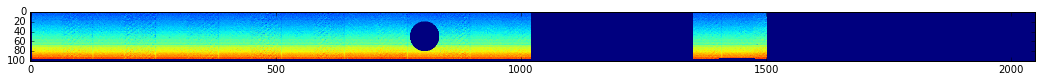

In [49]:
cube_start_framenum = 2083
cube_stop_framenum = 2282 # (inclusive)
sci_framenum = 1000

# read in cube
cube_string = (stem+'pca_cubes/background_PCA_seqStart_'+str("{:0>6d}".format(cube_start_framenum))+
               '_seqStop_'+str("{:0>6d}".format(cube_stop_framenum))+'.fits')

# filename string
img_string = stem+'lm_180524_'+str("{:0>6d}".format(sci_framenum))+'.fits'

# read in PCA cube
pca_cube = fits.getdata(cube_string,0,header=False)

# if FITS science file exists in the first place
if ((np.mod(sci_framenum,1) == 0) & os.path.isfile(img_string)): 
            
    print('Found file...')    
        
    # read in image
    sciImg, header = fits.getdata(img_string,0,header=True)
        
    # mask edges
    # (because these have blank regions due to overscan glitch correction,
    # and to avoid general weirdness)
    sciImg[0:4,:] = np.nan
    sciImg[-4:,:] = np.nan
    sciImg[:,0:4] = np.nan
        
    # mask other weird regions
    sciImg[:,1020:1350] = np.nan
    sciImg[94:,1402:1476] = np.nan
    sciImg[:,1500:] = np.nan
        
    ## mask the PSF (note this is done to the SCIENCE frames)
    
    # define region
    psf_loc = [50,803]
    center = PixCoord(x=psf_loc[1], y=psf_loc[0])
    radius = 30.
    region = CirclePixelRegion(center, radius)
    mask_psf_region = region.to_mask()

    # apply the mask to science array
    sciImg1 = np.copy(sciImg) # initialize arrays of same size as science image
    sciImg1.fill(1.) # initialize arrays of ones, with which we will multiply the science frame with
    mask_psf_region.data[mask_psf_region.data == 1] = np.nan  # make zeros within mask cutout (but not in the mask itself) nans
    mask_psf_region.data[mask_psf_region.data == 0] = 1
    sciImg1[mask_psf_region.bbox.slices] = mask_psf_region.data  # place the mask cutout (consisting only of 1s) onto the array of nans
    sciImg_masked = np.multiply(sciImg1,sciImg) # this is now the masked science frame
    
    # apply the mask to PCA cube (probably unnecessary)
    pca_cube_masked = np.multiply(pca_cube,sciImg1) 
    #print(sciImg_masked[50,1200])
    
    # sanity check
    
    plt.figure(figsize=(18,5))
    plt.imshow(pca_cube_masked[0,:,:])
    plt.show()
    
    
    ## PCA-decompose
    
    # flatten the science array and PCA cube 
    pca_not_masked_1ds = np.reshape(pca_cube,(np.shape(pca_cube)[0],np.shape(pca_cube)[1]*np.shape(pca_cube)[2]))
    sci_masked_1d = np.reshape(sciImg_masked,(np.shape(sciImg_masked)[0]*np.shape(sciImg_masked)[1]))
    pca_masked_1ds = np.reshape(pca_cube_masked,(np.shape(pca_cube_masked)[0],np.shape(pca_cube_masked)[1]*np.shape(pca_cube_masked)[2]))
    
    #pca = PCA(svd_solver='randomized', n_components=10) # initialize object
    #pca = RandomizedPCA(20)
    #test_pca = pca.fit(sci_1d
                      
    #components = pca.transform(faces.data)
    #projected = pca.inverse_transform(components))

In [59]:
plt.figure(figsize=(18,5))
plt.imshow(pca_cube_masked[1,:,:])
plt.colorbar()
plt.show()

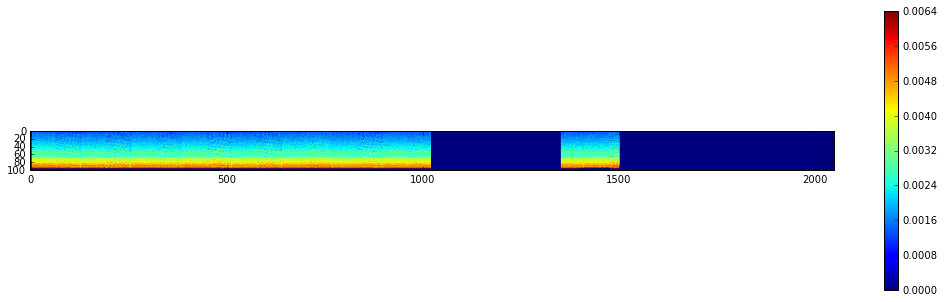

In [84]:
plt.figure(figsize=(18,5))
plt.imshow(pca_cube[0,:,:])
plt.colorbar()
plt.show()

In [103]:
np.shape(pca_1ds)

(100, 204800)

In [50]:
# the vector of component amplitudes

soln_vector = np.linalg.lstsq(pca_masked_1ds.T, sci_masked_1d)

# for just the first 10 PCA components:
##soln_vector = np.linalg.lstsq(pca_1ds[0:10,:].T, sci_1d)

In [51]:
# reconstruct the background by dotting the PCA components with the amplitude vector

recon_backgrnd = np.dot(pca_not_masked_1ds.T, soln_vector[0])

# for just the first 10 PCA components:
##recon_backgrnd = np.dot(pca_1ds[0:10,:].T, soln_vector[0])

In [8]:
soln_vector

(array([  3.53347885e+06,  -5.81452843e+04,   2.23373035e+04,
          2.62939720e+04,   5.33581073e+04,  -1.17654675e+05,
         -6.93842818e+04,  -7.05974129e+04,   2.20220056e+05,
         -9.89813160e+04,   2.02318691e+05,   5.66075952e+04,
         -8.93128222e+04,  -1.03179073e+05,  -3.43588521e+04,
         -4.93612902e+04,   9.95824183e+04,  -1.94240262e+04,
          9.84159697e+04,   3.10892480e+05,  -2.95327844e+05,
         -2.11483782e+05,  -4.87470507e+04,   5.87889284e+05,
         -4.32603739e+05,  -2.31624526e+05,  -1.06208089e+05,
          2.23933563e+05,  -9.84518702e+04,  -7.45561639e+04,
         -1.47637375e+05,  -1.43200793e+05,  -1.00686452e+05,
          1.62931959e+05,  -2.74049852e+04,  -2.50768516e+05,
         -7.27584004e+04,   2.81475698e+04,   3.63754153e+04,
         -1.14655222e+05,  -7.02014096e+04,  -1.15757887e+05,
          3.35809305e+04,  -1.99041187e+05,   1.59580251e+05,
         -1.47726776e+04,   1.19922182e+04,  -6.53919080e+04,
        

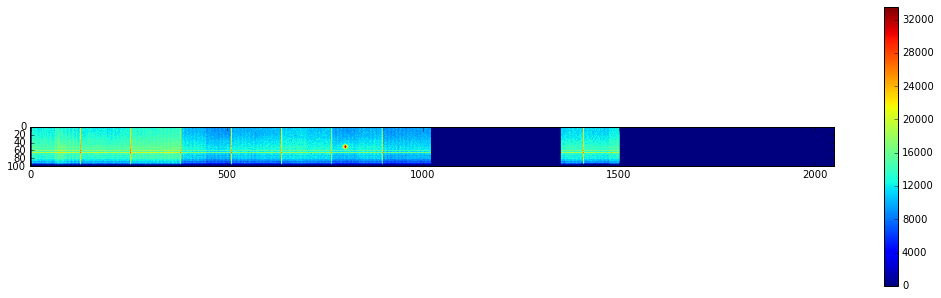

In [52]:
plt.figure(figsize=(18,5))
plt.imshow(sciImg)
plt.colorbar()
#plt.savefig('test_sci_not_masked.pdf')
plt.show()

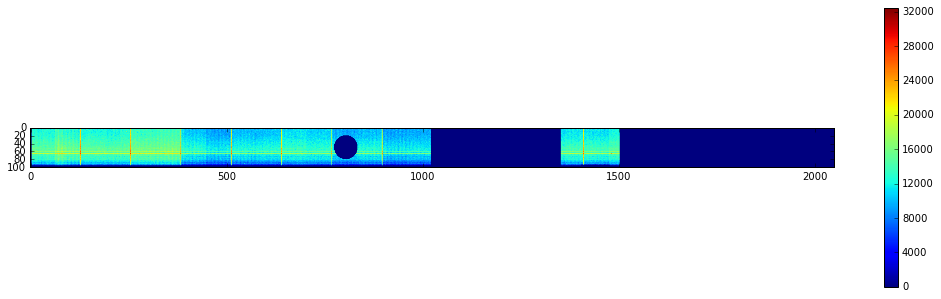

In [53]:
plt.figure(figsize=(18,5))
plt.imshow(sciImg_masked)
plt.colorbar()
#plt.savefig('test_sci_masked.pdf')
plt.show()

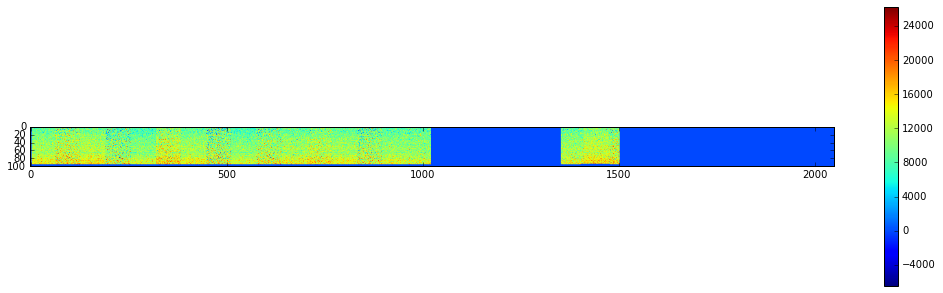

In [55]:
plt.figure(figsize=(18,5))
plt.imshow(recon_backgrnd.reshape(100,2048))
plt.colorbar()
#plt.savefig('reconstruc_backgrnd.pdf')
plt.show()

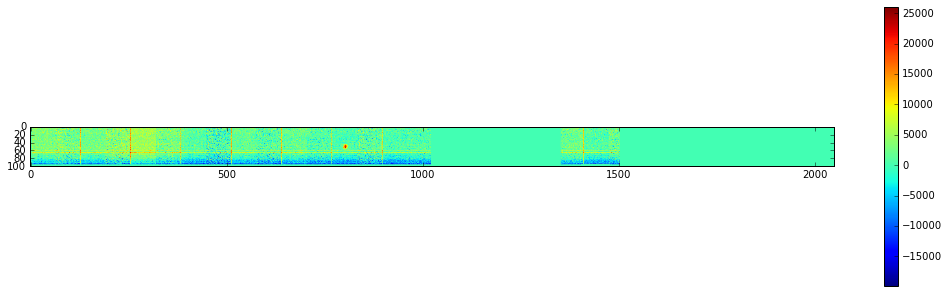

In [56]:
plt.figure(figsize=(18,5))
plt.imshow(np.subtract(sciImg,recon_backgrnd.reshape(100,2048)))
plt.colorbar()
#plt.savefig('bckgrnd_subt_residuals.pdf')
plt.show()

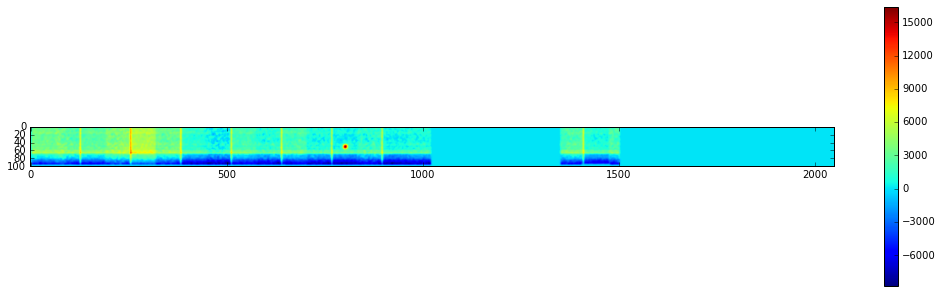

In [57]:
from scipy.ndimage.filters import gaussian_filter
filtered_arr=gaussian_filter(np.subtract(sciImg,recon_backgrnd.reshape(100,2048)), sigma=2)

plt.figure(figsize=(18,5))
plt.imshow(filtered_arr)
plt.colorbar()
#plt.savefig('bckgrnd_subt_residuals.pdf')
plt.show()

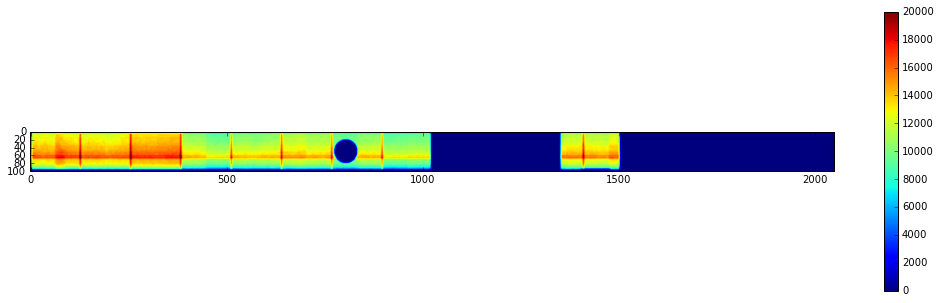

In [119]:
# smoothed masked science image

filtered_arr=gaussian_filter(sciImg_masked, sigma=2)

plt.figure(figsize=(18,5))
plt.imshow(filtered_arr, vmin=0, vmax=20000)
plt.colorbar()
#plt.savefig('reconstruc_backgrnd.pdf')
plt.show()

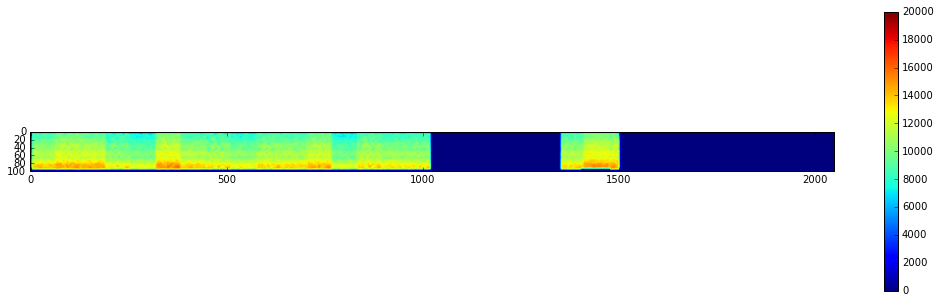

In [118]:
# smoothed reconstructed background

filtered_arr=gaussian_filter(recon_backgrnd.reshape(100,2048), sigma=2)

plt.figure(figsize=(18,5))
plt.imshow(filtered_arr, vmin=0, vmax=20000)
plt.colorbar()
#plt.savefig('reconstruc_backgrnd.pdf')
plt.show()

Fake science image


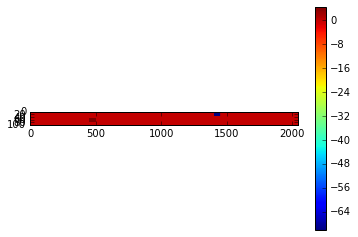

PCA cube 1 slices


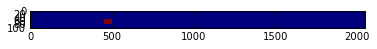

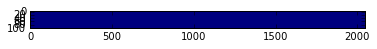

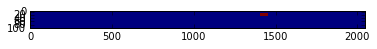

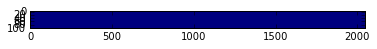

PCA cube 2 slices


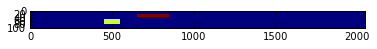

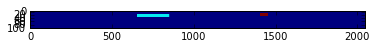

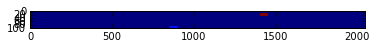

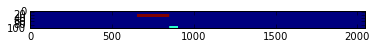

[  30000.       0. -100000.       0.]
Reconstructed background


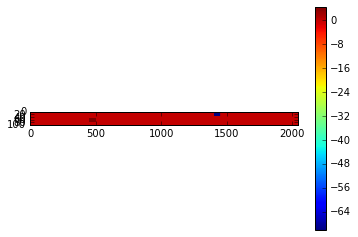

In [38]:
# test to see if I'm doing the background reconstruction right

# generate a fake science image with two squares in it of different amplitudes
fake_sci_image = np.zeros((100,2048))
fake_sci_image[50:78,450:550] = 4.5
fake_sci_image[20:40,650:850] = -12.5
fake_sci_image[15:35,1400:1450] = -70
fake_sci_image[90:,850:900] = 15


# make a cube of fake PCA components
fake_pca_cube = np.zeros((4,100,2048))
fake_pca_cube[0,50:78,450:550] = 0.00015
fake_pca_cube[1,20:40,650:850] = 0.00025
fake_pca_cube[2,15:35,1400:1450] = 0.0007
fake_pca_cube[3,90:,850:900] = 0.0001

# make another cube that is a mixture of the first cube's components
fake_pca_cube2 = np.copy(fake_pca_cube)
fake_pca_cube2[0,:,:] = np.mean([fake_pca_cube[0,:,:],fake_pca_cube[1,:,:]], axis=0)
fake_pca_cube2[1,:,:] = np.mean([fake_pca_cube[1,:,:],fake_pca_cube[2,:,:]], axis=0)
fake_pca_cube2[2,:,:] = np.mean([fake_pca_cube[2,:,:],fake_pca_cube[3,:,:]], axis=0)
fake_pca_cube2[3,:,:] = np.mean([fake_pca_cube[1,:,:],fake_pca_cube[3,:,:]], axis=0)

#fake_pca_cube = fake_pca_cube2 # rename, if I want to use the 2nd cube

# mimic a mask
fake_sci_image[:,500:1000] = 0 #np.nan 
fake_pca_cube[:,:,500:1000] = 0 #np.nan


print('Fake science image')
plt.imshow(fake_sci_image)
plt.colorbar()
plt.show()

print('PCA cube 1 slices')
for i in range(0,4):
    plt.imshow(fake_pca_cube[i,:,:])
    plt.show()
    
print('PCA cube 2 slices')
for i in range(0,4):
    plt.imshow(fake_pca_cube2[i,:,:])
    plt.show()

# flatten the science array and PCA cube 
fake_sci_image_1d = np.reshape(fake_sci_image,(np.shape(fake_sci_image)[0]*np.shape(fake_sci_image)[1]))
fake_pca_cube_1ds = np.reshape(fake_pca_cube,(np.shape(fake_pca_cube)[0],np.shape(fake_pca_cube)[1]*np.shape(fake_pca_cube)[2]))

# the vector of component amplitudes
soln_vector = np.linalg.lstsq(fake_pca_cube_1ds.T, fake_sci_image_1d)

# reconstruct the background by dotting the PCA components with the amplitude vector
recon_backgrnd = np.dot(fake_pca_cube_1ds.T, soln_vector[0])
recon_backgrnd_2d = recon_backgrnd.reshape(100,2048)

print(soln_vector[0])

print('Reconstructed background')
plt.imshow(recon_backgrnd_2d)
plt.colorbar()
plt.show()


In [29]:
recon_backgrnd[idx] = recon_backgrnd_noNaNs


/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 100 but corresponding boolean dimension is 204800
  if __name__ == '__main__':


ValueError: shape mismatch: value array of shape (104315,) could not be broadcast to indexing result of shape (104315,2048)

In [23]:
len(idx)

204800

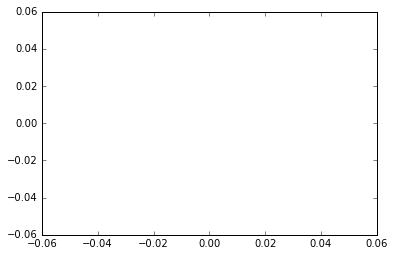

In [27]:
plt.plot(recon_backgrnd)
plt.show()